In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from transformers import BertTokenizer, TFBertModel, AutoTokenizer,TFAutoModel
import tensorflow as tf
from datasets import load_dataset
import kerastuner as kt
#import plotlib as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import warnings

warnings.filterwarnings('ignore') # ignore Jupiter warnings

2021-12-01 19:58:42.683807: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-01 19:58:42.683972: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

2021-12-01 19:58:50.393102: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-01 19:58:50.395916: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-12-01 19:58:50.395957: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-01 19:58:50.395990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5f44c8e08020): /proc/driver/nvidia/version does not exist
2021-12-01 19:58:50.400284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [3]:
model_roBerta ='joeddav/xlm-roberta-large-xnli'
#model_Bert = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_roBerta)
model = TFAutoModel.from_pretrained(model_roBerta)

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [4]:
os.environ["WANDB_API_KEY"] = "0" ## 0 to silence 

In [5]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

In [6]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [7]:
test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


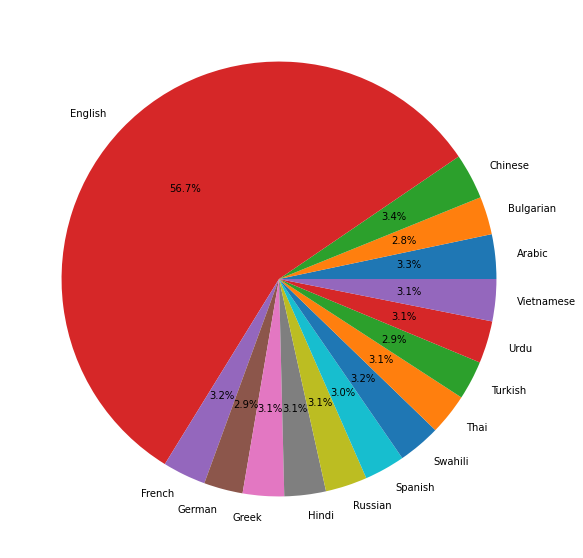

In [8]:
import matplotlib.pyplot as plt
labels, frequencies =np.unique(train['language'], return_counts=True)
plt.figure(figsize=[10, 10])
plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
plt.show()

In [9]:
def load_mnli(use_validation=True):
    result=[]
    dataset=load_dataset('multi_nli')
    print(dataset)
    for record in dataset['train']:
        c1, c2, c3 = record['premise'],record['hypothesis'], record['label']
        if c1 and c2 and c3 in {0, 1, 2}:
            result.append((c1, c2, c3, 'en'))
    result=pd.DataFrame(result, columns=['premise', 'hypothesis', 'label', 'lang_abv'])
    return result

In [10]:
mnli=load_mnli()
mnli

Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/227M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})


,premise,hypothesis,label,lang_abv
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en
3,How do you know? All this is their information...,This information belongs to them.,0,en
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en
...,...,...,...,...
392697,"Clearly, California can - and must - do better.",California cannot do any better.,2,en
392698,It was once regarded as the most beautiful str...,So many of the original buildings had been rep...,1,en
392699,Houseboats are a beautifully preserved traditi...,The tradition of houseboats originated while t...,0,en
392700,Obituaries fondly recalled his on-air debates ...,The obituaries were beautiful and written in k...,1,en


In [11]:
train = train[['premise', 'hypothesis', 'lang_abv', 'label']]
train

,premise,hypothesis,lang_abv,label
0,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,0
1,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,2
2,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,0
3,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,0
4,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,1
...,...,...,...,...
12115,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,2
12116,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,0
12117,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,2
12118,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,2


In [12]:
mnli=mnli[['premise', 'hypothesis', 'lang_abv', 'label']]
mnli

,premise,hypothesis,lang_abv,label
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,en,1
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,en,0
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,en,0
3,How do you know? All this is their information...,This information belongs to them.,en,0
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,en,1
...,...,...,...,...
392697,"Clearly, California can - and must - do better.",California cannot do any better.,en,2
392698,It was once regarded as the most beautiful str...,So many of the original buildings had been rep...,en,1
392699,Houseboats are a beautifully preserved traditi...,The tradition of houseboats originated while t...,en,0
392700,Obituaries fondly recalled his on-air debates ...,The obituaries were beautiful and written in k...,en,1


In [13]:
train=pd.concat([train, mnli.loc[:20000]], axis=0)

In [14]:
train.shape

(32121, 4)

In [15]:
SEQ_LEN = 236  #50 #max(train.astype('str').applymap(lambda x: len(x)).max())

def bert_encode(df, tokenizer):    
    batch_premises = df['premise'].tolist()
    batch_hypothesis = df['hypothesis'].tolist()

    tokens = tokenizer(batch_premises, batch_hypothesis, max_length = SEQ_LEN,
                   truncation=True, padding='max_length',
                   add_special_tokens=True, return_attention_mask=True,
                   # return_token_type_ids=True, only for BERT
                   return_tensors='tf')
    inputs = {
          'input_ids': tokens['input_ids'], 
          'attention_mask': tokens['attention_mask'],
          } # 'token_type_ids': tokens['token_type_ids']    only for BERT
    return inputs

In [16]:
train_input = bert_encode(train, tokenizer)

In [17]:
from tensorflow.keras import regularizers

def build_model():   # hp
    #FBertModel
    encoder = TFAutoModel.from_pretrained(model_roBerta)
    input_ids = tf.keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name="attention_mask")
    # token_type_ids = tf.keras.Input(shape=(SEQ_LEN,), 
                                    #dtype=tf.int32,  name="token_type_ids")  only for BERT  
        
    embedding = encoder([input_ids, attention_mask])[0] 
    inputs=[input_ids, attention_mask] 
    hp_units1 = 64 # hp.Int('Inits1', min_value = 32, max_value = 512, step = 32)
    hp_units2 = 32 #hp.Int('Inits2', min_value = 32, max_value = 512, step = 32)
    x = tf.keras.layers.Dense(units = hp_units1, activation=tf.nn.relu)(embedding[:,0,:])
    #x = tf.keras.layers.Conv1D(128, 3, activation=tf.nn.relu)(embedding[:,0,:])                                                          
    #x = tf.keras.layers.GlobalMaxPool1D(64, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(units = hp_units2, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(l2=1e-4))(x)
    output = tf.keras.layers.Dense(3, activation='softmax')(x)    #  (embedding[:,0,:])
      
    model = tf.keras.Model(inputs=inputs, outputs=output)
    hp_learning_rate = 1e-6 # hp.Choise('learning_rate', values = [1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]) hp_learning_rate
    model.compile(tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])   
    return model 


In [18]:
with strategy.scope(): # defines the compute distribution policy for building the model. or in other words: makes sure that the model is created on the TPU/GPU/CPU, depending on to what the Accelerator is set in the Notebook Settings
    model = build_model() # our model is being built
    model.summary()       # let's look at some of its properties
    #tuner = kt.Hyperband(build_model, objectinve = 'sparse_categorical_crossentropy', 
                         #max_epchs = 10)
   

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 236)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 236)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model_1 (TFXLMRob TFBaseModelOutputWit 559890432   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 1024)         0           tfxlm_roberta_model_1[0][0]  

In [19]:
for key in train_input.keys():
    train_input[key] = train_input[key][:,:SEQ_LEN]

In [20]:
#early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
# make sure that TPU in Accelerator under Notebook Settings is turned on so that model trains on the TPU. Otherwise this line will crash
#hist = History()train.label.values
#labels = tf.cast(train['label'], dtype=tf.int32)
history = model.fit(train_input, train['label'], epochs = 10, batch_size=64, 
                    validation_split = 0.2) #,callbacks=[hist]) verbose = 1,              

Epoch 1/10
402/402 [==============================] - 377s 585ms/step - loss: 0.4794 - accuracy: 0.7989 - val_loss: 0.1727 - val_accuracy: 0.9465
Epoch 2/10
402/402 [==============================] - 119s 297ms/step - loss: 0.2082 - accuracy: 0.9333 - val_loss: 0.1680 - val_accuracy: 0.9460
Epoch 3/10
402/402 [==============================] - 119s 297ms/step - loss: 0.1844 - accuracy: 0.9410 - val_loss: 0.1599 - val_accuracy: 0.9489
Epoch 4/10
402/402 [==============================] - 119s 297ms/step - loss: 0.1666 - accuracy: 0.9468 - val_loss: 0.1593 - val_accuracy: 0.9497
Epoch 5/10
402/402 [==============================] - 119s 297ms/step - loss: 0.1485 - accuracy: 0.9520 - val_loss: 0.1604 - val_accuracy: 0.9483
Epoch 6/10
402/402 [==============================] - 119s 297ms/step - loss: 0.1387 - accuracy: 0.9561 - val_loss: 0.1708 - val_accuracy: 0.9479
Epoch 7/10
402/402 [==============================] - 119s 297ms/step - loss: 0.1295 - accuracy: 0.9589 - val_loss: 0.1675 -

In [21]:
# tuner.search(train_input, train['label'], epochs = 10, batch_size=32, 
                #validation_split = 0.2)

In [22]:
#for h_param in [f'units{i}' for i in range (1, 7)] + ['learning_rate']:
#    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))
    

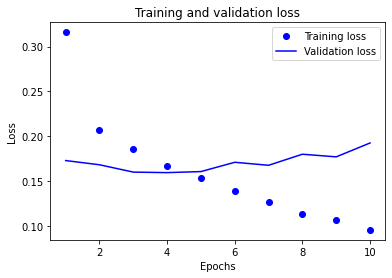

In [23]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

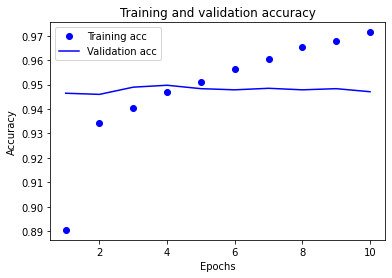

In [24]:
plt.clf() #Очистить рисунок
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
test_input = bert_encode(test, tokenizer) 

In [26]:
 #same for the test set we need to put it in the same size of the model
for key in test_input.keys():
    test_input[key] = test_input[key][:,:SEQ_LEN]

In [27]:
predictions = [np.argmax(i) for i in model.predict(test_input)]
model.evaluate(test_input)

163/163 [==============================] - 13s 25ms/step - loss: 0.0043 - accuracy: 0.0000e+00


[0.004269542172551155, 0.0]

In [28]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [29]:
submission.to_csv("./submission.csv", index = False)

In [30]:
submission.head()

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1
